In [1]:
import torch
import pandas as pd
import random
from epifit.network_generation import generate_random_network
from epifit.graphing_utils import *
from matplotlib import pyplot as plt
#from epifit.transitions import S_I

device = "cuda" if torch.cuda.is_available() else "cpu"

def Population(n:int, device= "cpu"):
  initial_population = { #a columnar DB somewhat reminds the Pandas DataFrame 
      "I":torch.zeros(n).to(device),
      "susceptiveness":torch.ones(n).to(device).requires_grad_(True)*1.0,
      "infectiveness":torch.ones(n).to(device).requires_grad_(True)*1.0
  }
  initial_population["I"][0]=1 #first one infective
  return initial_population

def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter.item()))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')

class SI_dense(torch.nn.Module):
    """
    Stochastic individual base (S)usceptible-(I)nfective transition. 
    The infective agent propagates through an unweighted contact network 
    stored as a dense Tensor.     
    """
    def __init__(self, contact_net, pinf, I_name, susceptiveness_name, infectiveness_name, device, start=0):
        super(SI_dense,self).__init__()
        self._contact_net = contact_net
        self._pinf = torch.nn.parameter.Parameter(torch.Tensor([pinf]).to(device)) # set it as trainnable
        self._n = contact_net.size()[0]
        self._t = 0
        self._start = start
        self._states_names = {'I': I_name, 'susceptiveness': susceptiveness_name, 'infectiveness': infectiveness_name}
        
    def forward(self, states):
        self._t+=1
        if self._t >= self._start:
            I = states[self._states_names['I']] # boolean state of being infected
            susceptiveness = states[self._states_names['susceptiveness']] # floating point, number between 0 and 1 means probability of being infected
            infectiveness = states[self._states_names['infectiveness']] # floating point, number between 0 and 1 means probability of infecting another
            
            susceptible = (I==0).float()
            susceptible*=susceptiveness
            susceptible = susceptible.unsqueeze(dim=1)
            infective=infectiveness*I
            infective=infective*self._pinf
            infective = infective.unsqueeze(dim=0)

            con = self._contact_net*infective*susceptible#n*n, 1*n (row multiply), n*1 (column multiply)
            #why do like this?
            con = torch.log(1 - con)     
            dI = 1 - torch.exp(con.mm(torch.ones(self._n).to(device).unsqueeze(dim=1)).squeeze()) # probability of being infected that day
            #print(dI)
            dIsample= torch.rand(self._n).to(device)

            #dI = torch.rand(self._n, requires_grad=True).to(device) < dI 
            #random will effect the result, less than operation will lose gradient

            activeM= torch.nn.Sigmoid()

            dI= activeM(1000*(dI-dIsample))

            I = torch.max(I, dI) # got infected

            states[self._states_names['I']] = I

        return states

In [2]:
def sim(time_horizon, population, model):
  log = [population['I']]
  for i in range(time_horizon):
    population = model(population)
    log.append(population['I'])  
  log = torch.stack(log)
  log = log.unsqueeze(dim=1)
  log = log.unsqueeze(dim=0)
  return log

In [9]:
n = 5000 # population
avgDegree = 10  #every individual will have 10 contacts on average
pinf = 0.2  #it is the first parameter we are going to fit
time_horizon = 20

#create  dense contacts
contacts = generate_random_network(n, avgDegree)
contacts = contacts.coalesce()#make pairs unique
print(contacts.values().sum())
contacts = contacts.to_dense()
contacts = contacts.requires_grad_(True)
#si true 
si =     SI_dense(contacts, pinf=pinf, I_name="I",susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", device=device)
#si fit
si_fit = SI_dense(contacts, pinf=0.05, I_name="I", susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", device=device)
#deinfe loss function
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(si_fit.parameters(), lr=5e-3)
#generate real data
si_result= None
with torch.no_grad():
    population = Population(n, device=device)
    si_result = sim(time_horizon,population,si)
si_result.requires_grad_(True)
stats_gt   = si_result.sum(dim=3) # si along 20 iterations

tensor(50000., device='cuda:0')


0   0.05000000074505806
1   0.054999999701976776
2   0.059258945286273956
3   0.06377142667770386
4   0.06835157424211502
5   0.07306969910860062
6   0.07789723575115204
7   0.08275473117828369
8   0.08764655143022537
9   0.09252802282571793
10   0.09750986844301224
11   0.10258087515830994
12   0.10702232271432877
13   0.1112213283777237
14   0.11527396738529205
15   0.11937250941991806
16   0.12348143756389618
17   0.12770581245422363
18   0.13191655278205872
19   0.13587933778762817
20   0.1395985335111618
21   0.14317665994167328
22   0.1465263068675995
23   0.1497640311717987
24   0.15284359455108643
25   0.15577690303325653
26   0.1595601588487625
27   0.1630757600069046
28   0.166339710354805
29   0.1693718582391739
30   0.17221975326538086
31   0.17489615082740784
32   0.1775275319814682
33   0.17999665439128876
34   0.18229277431964874
35   0.18441076576709747
36   0.18639472126960754
37   0.18828734755516052
38   0.19001536071300507
39   0.19162416458129883
40   0.19314655661

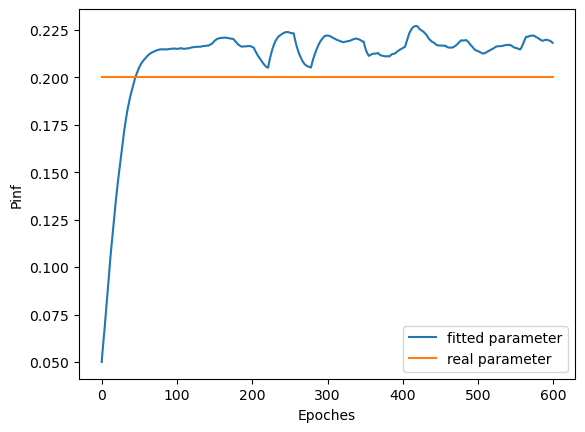

In [10]:
fitPinfs=[]
#gradient direction: negative-> positive
for i in range(600):
    print(i, " ", si_fit._pinf.item())
    optimizer.zero_grad()
    fitPinfs.append(si_fit._pinf.item())
    population = Population(n, device=device)
    si_pred = sim(time_horizon, population, si_fit)
    stats_pred = si_pred.sum(dim=3)
    loss = loss_fn(stats_gt, stats_pred)
    loss.backward(retain_graph=True)
    optimizer.step()

print_model_parameters(si_fit)
colors = [("red", 'I')]
age_sizes = [n]
#plot(si_pred.detach(), colors, age_sizes, by_age=False, title=f"SEIDRV, social to bio and bio to social transitions", percent_extremes_remove=0.1)
#plot(si_result.detach(), colors, age_sizes, by_age=False, title=f"SEIDRV, social to bio and bio to social transitions", percent_extremes_remove=0.1)
plt.plot(fitPinfs, label='fitted parameter')
plt.plot([pinf]*len(fitPinfs), label='real parameter')
plt.xlabel("Epoches")
plt.ylabel("Pinf")
plt.legend()
